In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Input, BatchNormalization, Dropout, Dense, Flatten
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import balanced_accuracy_score

### Denoising Autoencoder (DAE)

Denoising Autoencoders or DAEs come under the set of unsupervised approaches in Machine Learning. The idea of DAEs is to make the model robust by feeding the model noisy input so that it can learn better. By adding noise to input, we are making it difficult for the NN to learn, similar to dropout where we randomly turn off neurons. The latter (similar to former) also aims to induce some amount of regularization (or randomness) in learning therby making the model robust and prevent overfitting.

DAEs can also be used to dimensionally reduce the data. In the reduced latent/embedding space, in order to be able to recognize objects in image or perform other tasks, the model is going to focus on the most informative parts of input and learn to store that information in embedded (constrained) space therby eliminating noise as well.

In [2]:
img_size = 28
num_classes = 10
learning_rate = 1E-4
n_epochs = 15
batch_size = 64
sample_pct = 0.05

In this notebook, we build DAE on MNIST dataset. We will build a small model having downsampling (encoder) and upsampling (decoder) path, similar to UNet, ensuring the size of output is same as that of input, and minimize the reconstruction loss using MSE loss function.

In [3]:
(X, y), (X_test, y_test) = keras.datasets.mnist.load_data()
idx = np.arange(len(X))
np.random.shuffle(idx)

# sampling for faster training
sample_size = int(sample_pct * len(X))
sample_idxs = idx[:sample_size]
X = X[sample_idxs]
y = y[sample_idxs]

X.shape, y.shape, X_test.shape, y_test.shape

((3000, 28, 28), (3000,), (10000, 28, 28), (10000,))

Label: 2
Noise strength: 44 pixels


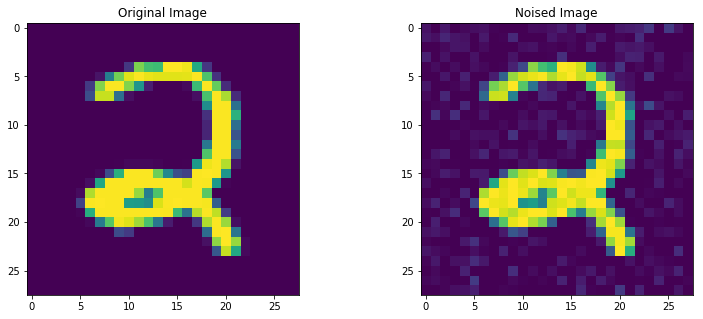

In [4]:
def add_noise(img, print_strength=False):
    mu = np.mean(img)
    sigma = np.std(img)
    img = (img - mu) / sigma

    std_noise = np.abs(np.random.normal())
    std_noise = np.clip(std_noise, -1, 1)

    if print_strength:
        print(f'Noise strength: {int(std_noise * 255)} pixels')
    noise = np.random.normal(0, std_noise, img.shape)
    
    img += noise
    img = img * sigma + mu
    img = np.clip(img, 0, 255)
    img = img.astype('uint8')
    return img
    
idx = 89
label = y[idx]
img = X[idx]
print('Label:', label)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(132)
noised_image = add_noise(img, print_strength=True)
plt.imshow(noised_image)
plt.title('Noised Image')
plt.show()

In [5]:
inp = Input(shape=(img_size, img_size, 1))

# encoder
x = Conv2D(64, kernel_size=(2,2), activation='relu')(inp)
x = Conv2D(128, kernel_size=(2,2), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)

# embedding
x = BatchNormalization()(x)
emb = Dropout(0.25, name='embedding')(x)

# decoder
x = Conv2DTranspose(128, kernel_size=(2,2), strides=(2,2), output_padding=(1,1), activation='relu')(emb)
x = Conv2DTranspose(64, kernel_size=(2,2), activation='relu')(x)
out = Conv2DTranspose(1, kernel_size=(1,1), activation='relu')(x)

model = Model(inputs = inp, outputs = out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 27, 27, 64)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 128)       32896     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 128)      512       
 ormalization)                                                   
                                                                 
 embedding (Dropout)         (None, 13, 13, 128)       0     

2022-04-04 14:34:28.517822: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def add_noise(img):
    std_noise = np.abs(np.random.normal())
    std_noise = np.clip(std_noise, -1, 1)
    noise = np.random.normal(0, std_noise, img.shape)
    img += noise
    img = np.clip(img, 0, 255)
    return img

datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True, 
                            dtype='uint8', preprocessing_function = add_noise, validation_split=0.2)

X = np.expand_dims(X, axis=3)
X_test = np.expand_dims(X_test, axis=3)
train_img_generator = datagen.flow(X, X, batch_size=batch_size, subset='training')
val_img_generator = datagen.flow(X, X, batch_size=batch_size, subset='validation')

In [7]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(train_img_generator, epochs = n_epochs, shuffle = True, 
                    validation_data = val_img_generator, verbose=1)

Epoch 1/15
38/38 [==============================] - 8s 197ms/step - loss: 6948.4043 - val_loss: 7123.0498
Epoch 2/15
38/38 [==============================] - 7s 191ms/step - loss: 6003.2124 - val_loss: 6762.1890
Epoch 3/15
38/38 [==============================] - 8s 218ms/step - loss: 3673.5837 - val_loss: 5585.6309
Epoch 4/15
38/38 [==============================] - 8s 204ms/step - loss: 1467.3507 - val_loss: 4346.4570
Epoch 5/15
38/38 [==============================] - 8s 217ms/step - loss: 931.6094 - val_loss: 3935.5520
Epoch 6/15
38/38 [==============================] - 8s 214ms/step - loss: 830.6100 - val_loss: 3764.6262
Epoch 7/15
38/38 [==============================] - 8s 205ms/step - loss: 744.6379 - val_loss: 3467.0830
Epoch 8/15
38/38 [==============================] - 7s 193ms/step - loss: 656.8395 - val_loss: 3249.1863
Epoch 9/15
38/38 [==============================] - 8s 209ms/step - loss: 564.7885 - val_loss: 2925.0881
Epoch 10/15
38/38 [==============================] 

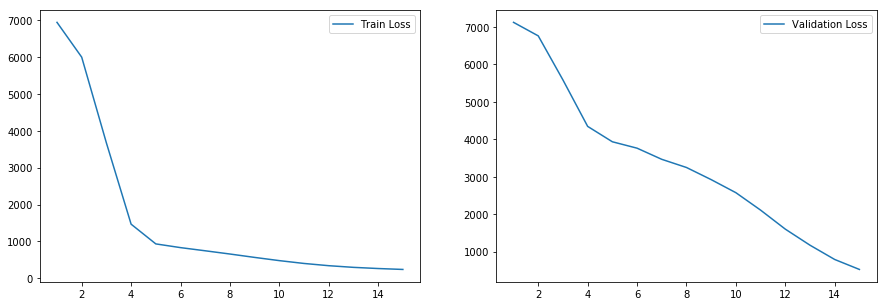

In [8]:
def plotting(train_loss, val_loss):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(range(1, n_epochs+1), train_loss, label = 'Train Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(range(1, n_epochs+1), val_loss, label = 'Validation Loss')
    plt.legend()

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plotting(train_loss, val_loss)    

In [9]:
def predict_example(idx, X_true, X_pred):
    gt = np.squeeze(X_true[idx])
    prediction = np.squeeze(X_pred[idx])

    plt.subplot(121)
    plt.imshow(gt)

    plt.subplot(122)
    plt.imshow(prediction)
    plt.show()

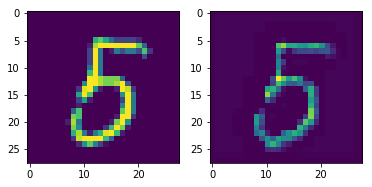

In [10]:
X_pred = model.predict(X_test)

idx = 45
predict_example(idx, X_test, X_pred)

### Finetuning for MNIST Classification
#### Using pre-trained weights from DAE 

We will now train a multi-class classifier with learnt weights from Autoencoder. We will freeze the model till embeddings (latent representations) and add another head (classifier) with additional trainable layers, thereby finetuning a classfication model with learnt/pre-trained weights.

In [11]:
model_clf = Sequential()
for layer in model.layers:
    layer.trainable = False
    model_clf.add(layer)
    if layer.name=='embedding':
        break

model_clf.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model_clf.add(MaxPool2D(pool_size=(3,3)))
model_clf.add(BatchNormalization())
model_clf.add(Dropout(0.5))
model_clf.add(Flatten())
model_clf.add(Dense(num_classes, activation='softmax'))
model_clf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 64)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 128)       32896     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 128)      512       
 ormalization)                                                   
                                                                 
 embedding (Dropout)         (None, 13, 13, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 128)       1

In [12]:
X = np.squeeze(X)
X_test = np.squeeze(X_test)

In [13]:
learning_rate = 1E-4
n_epochs = 20
batch_size = 64

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model_clf.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

history = model_clf.fit(X, y, epochs = n_epochs, shuffle = True, 
                    validation_split = 0.2, verbose=1)

Epoch 1/20
75/75 [==============================] - 4s 49ms/step - loss: 2.3582 - val_loss: 0.9880
Epoch 2/20
75/75 [==============================] - 3s 39ms/step - loss: 1.2015 - val_loss: 0.5256
Epoch 3/20
75/75 [==============================] - 3s 36ms/step - loss: 0.8534 - val_loss: 0.4130
Epoch 4/20
75/75 [==============================] - 3s 43ms/step - loss: 0.6807 - val_loss: 0.3735
Epoch 5/20
75/75 [==============================] - 4s 48ms/step - loss: 0.5717 - val_loss: 0.3326
Epoch 6/20
75/75 [==============================] - 3s 43ms/step - loss: 0.4706 - val_loss: 0.3009
Epoch 7/20
75/75 [==============================] - 3s 41ms/step - loss: 0.4501 - val_loss: 0.2881
Epoch 8/20
75/75 [==============================] - 3s 40ms/step - loss: 0.4028 - val_loss: 0.2685
Epoch 9/20
75/75 [==============================] - 3s 40ms/step - loss: 0.3484 - val_loss: 0.2624
Epoch 10/20
75/75 [==============================] - 3s 40ms/step - loss: 0.3385 - val_loss: 0.2467
Epoch 11/

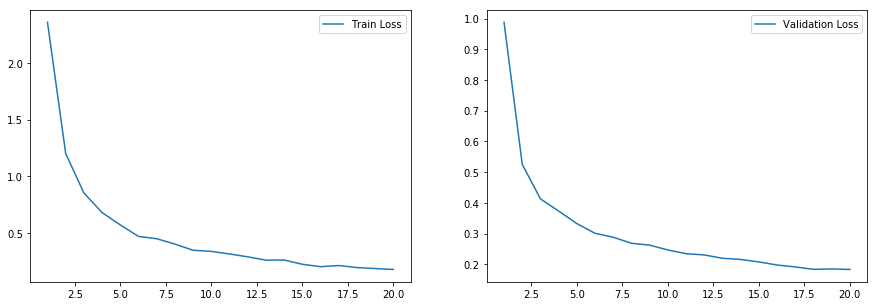

In [14]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plotting(train_loss, val_loss)    

In [15]:
y_pred = model_clf.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

acc_score = balanced_accuracy_score(y_test, y_pred)
print('Accuracy Score:', acc_score.round(2))

Accuracy Score: 0.96
